In [1]:
import torch
import numpy as np
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries
from PIL import Image


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load pre-trained ResNet50 model
model = models.resnet50(weights=True)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /Users/kierangivens/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


URLError: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1002)>

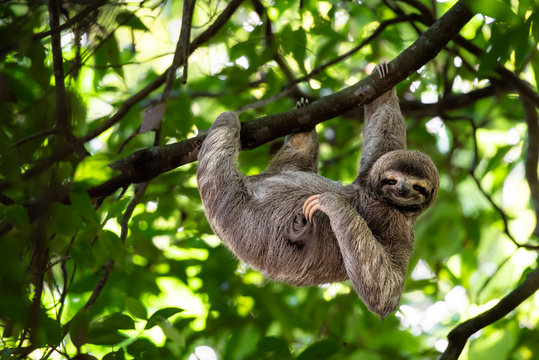

In [3]:
# Load and preprocess the image
image_path = "data/sloth.jpg"  # Replace with actual image path
image = Image.open(image_path)
image 

In [4]:
## normalizes the image pixel values using the mean and standard 
## deviation of the ImageNet dataset.
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

## format (C x H x W, where C=3 for RGB)
##add an exter dim for batch process -even though its only one image
image_tensor = transform(image).unsqueeze(0)  # Add batch dimension


In [7]:
# Function to predict from model
def predict_fn(images):
    images = np.stack([transform(Image.fromarray(img.astype(np.uint8))) for img in images])
    images = torch.tensor(images, dtype=torch.float32)
    
    with torch.no_grad():
        outputs = model(images)
    
    return torch.nn.functional.softmax(outputs, dim=1).numpy()


100%|██████████| 1000/1000 [00:39<00:00, 25.34it/s]


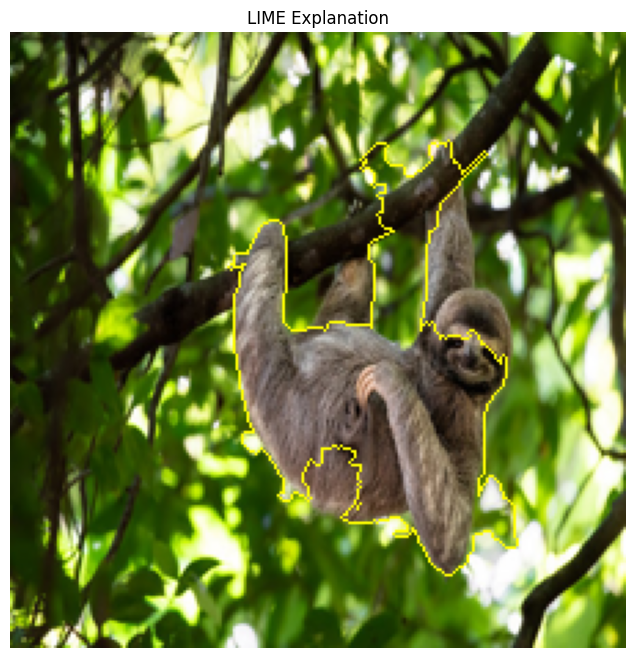

In [8]:
# LIME explanation
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(
    np.array(image.resize((224, 224))),
    predict_fn,
    top_labels=5,
    hide_color=0,
    num_samples=1000
)

# Get explanation mask for the top class
top_label = explanation.top_labels[0]
temp, mask = explanation.get_image_and_mask(top_label, positive_only=True, num_features=5, hide_rest=False)

# Visualize the LIME explanation
plt.figure(figsize=(8, 8))
plt.imshow(mark_boundaries(temp, mask))
plt.axis("off")
plt.title("LIME Explanation")
plt.show()
